<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Traveling_Salesman_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import itertools
import networkx as nx
from pyomo.contrib.latex_printer import latex_printer


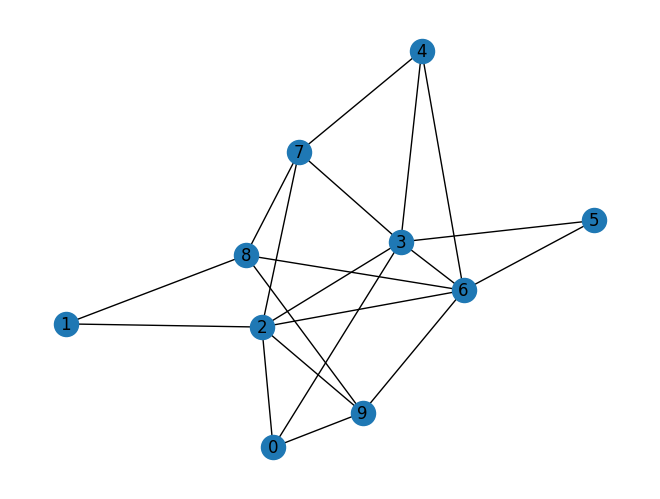

In [103]:
n = 10
m = 20
seed = 100

random.seed(seed)

G = nx.gnm_random_graph(n,m,seed)
nx.set_edge_attributes(G, {e: {'weight': random.randint(1, 5)} for e in G.edges})
pos = nx.spring_layout(G, seed = seed)
nx.draw(G, pos, with_labels = True)

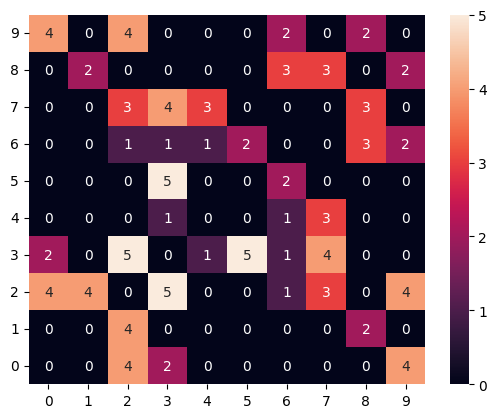

In [104]:
A = nx.to_numpy_array(G)
sns.heatmap(A, annot=True).invert_yaxis();
plt.yticks(rotation=0);

In [105]:
weights = {}
for i,j in G.edges:
  weights[(i,j)] = nx.to_dict_of_dicts(G)[i][j]['weight']
  weights[(j,i)] = nx.to_dict_of_dicts(G)[i][j]['weight']

#weights

\begin{align}
\text{Minimize } & \sum_{i=0}^{n} \sum_{j=0}^{n} C_{ij} X_{ij} \\
\text{subject to:} \nonumber \\
& \sum_{j=0, j \neq i}^{n} X_{ij} = 1 \quad \forall i \in \{0,1,\ldots,n\} \quad \text{(1)} \\
& \sum_{i=0, i \neq j}^{n} X_{ij} = 1 \quad \forall j \in \{0,1,\ldots,n\}\quad \text{(2)} \\
& u_j \geq u_i + 1 - M*(1-X_{ij}) \quad \forall i \neq j, \; i, j \in \{1,2, \ldots, n\} \quad \text{(3)} \\
& X_{ij} \in \{0, 1\} \quad \forall i, j \in \{0,1,\ldots,n\} \quad \text{(4)}
\end{align}

In [106]:
M = 1000

model = ConcreteModel()

model.I = RangeSet(0,n-1)

model.C = Param(model.I, model.I, initialize = weights)

model.X = Var(model.I, model.I, within = Boolean)

model.U = Var(model.I, within = NonNegativeReals)

# Each node has outgoing edge

def con1_rule(model,i):
  return sum(model.X[(i,j)] for j in model.I if (i,j) in G.edges) == 1
model.con1 = Constraint(model.I, rule = con1_rule)

# Each node has incoming edge

def con2_rule(model,j):
  return sum(model.X[(i,j)] for i in model.I if (i,j) in G.edges) == 1
model.con2 = Constraint(model.I, rule = con2_rule)

# Each node cannot go into itself

def con3_rule(model,i):
  return model.X[(i,i)] == 0
model.con3 = Constraint(model.I, rule = con3_rule)

# Subtour elimination: Miller, Tucker, Zemlin method

def con4_rule(model,i,j):
  if (i,j) in G.edges and j != 0:
    return model.U[j] >= model.U[i] + 1 - M*(1-model.X[(i,j)])
  else:
    return Constraint.Skip
model.con4 = Constraint(RangeSet(1,n-1), RangeSet(1,n-1), rule = con4_rule)

# Objective function

model.obj = Objective(expr = sum(model.C[(i,j)] * model.X[(i,j)] for i in model.I for j in model.I if (i,j) in G.edges))

In [107]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.06


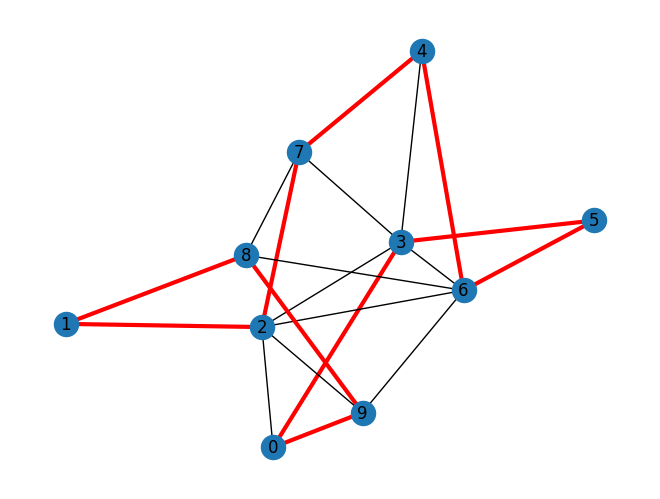

In [109]:
x = model.X.extract_values()

colors = []
width = []

for (i,j) in G.edges:
  if x[i,j] == 1 or x[j,i] == 1:
    colors.append('r')
    width.append(3)
  else:
    colors.append('k')
    width.append(1)

random.seed(seed)

G = nx.gnm_random_graph(n,m,seed)
nx.set_edge_attributes(G, {e: {'weight': random.randint(1, 5)} for e in G.edges})
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos, edge_color=colors, width = width, with_labels = True)